# EMLaunch - Monte Carlo Trajectory Analysis

Electromagnetic launcher simulation with stochastic uncertainty quantification.

**Configuration:** 5 km vacuum tube launcher, 18 kV, ultra-low drag  
**Goal:** Reach LEO (400 km altitude)

**Author:** Barak Bercovitz (barakber@gmail.com)

## Theory

**Electromagnetic Force:** $F_{em} = \frac{1}{2} I^2 \frac{dL}{dx}$

**Stochastic Model:** $d\mathbf{X} = f(\mathbf{X}, t)dt + g(\mathbf{X}, t)d\mathbf{W}$

**Drag:** $F_{drag} = \frac{1}{2} \rho v^2 C_D A$

⚠️ **Cargo-only:** ~500-1000g acceleration

## Setup

In [11]:
# Activate project and load package
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
using EMLaunch
using Unitful

println("="^70)
println("EMLaunch - Monte Carlo Trajectory Analysis")
println("="^70)

EMLaunch - Monte Carlo Trajectory Analysis


  Activating project at `~/Development/EMLaunch`


## Configuration

In [12]:
# HIGH-PERFORMANCE VACUUM TUBE LAUNCHER
launcher = create_uniform_launcher(
    length = 5000.0u"m",               # 5 km tube (ambitious but feasible)
    num_coils = 500,                   # 10m coil spacing
    inductance_per_coil = 0.001u"H",
    resistance_per_coil = 0.01u"Ω",
    capacitance_per_coil = 2.5u"F",    # High-capacity supercaps
    voltage_per_coil = 18000.0u"V",    # 18 kV for high power
    gradient_per_coil = 0.003u"H/m",   # Strong gradient
    vacuum_pressure_ratio = 0.0001     # 99.99% vacuum (ultra-high vacuum)
)

# PAYLOAD: Aerodynamic projectile
payload = PayloadConfig(
    10.0u"kg",                         # 10 kg
    π * (0.05u"m")^2,                  # 10 cm diameter
    0.02u"m",                          # Sharp nose
    0.95,
    900.0u"J/(kg*K)",
    288.15u"K",
    2500.0u"K"                         # Higher thermal limit
)

# MISSION: Near-vertical launch
mission = MissionProfile(
    0.0u"m",               # Sea level
    32.5u"°",              # Caesarea, Israel
    34.9u"°",
    90.0u"°",              # East
    88.0u"°",              # 88° (nearly vertical)
    8000.0u"m/s",
    400.0u"km"
)

# Summary
E_per_coil = 0.5 * launcher.coils[1].capacitance * launcher.coils[1].voltage^2
E_total = launcher.num_coils * E_per_coil
efficiency = 0.40  # Higher efficiency in vacuum
m = ustrip(u"kg", payload.mass)
KE_available = efficiency * ustrip(u"J", E_total)
v_exit_estimate = sqrt(2 * KE_available / m)

println("Launcher: $(launcher.length), $(launcher.num_coils) coils @ $(round(ustrip(launcher.coils[1].voltage)/1000, digits=1)) kV")
println("Vacuum:   $(round((1-launcher.vacuum_pressure_ratio)*100, digits=2))% (ultra-high vacuum)")
println("Payload:  $(payload.mass), ⌀$(round(ustrip(u"m", sqrt(payload.area/π))*2*100, digits=1)) cm")
println("Energy:   $(round(ustrip(u"MJ", E_per_coil), digits=1)) MJ/coil, $(round(ustrip(u"GJ", E_total), digits=2)) GJ total")
println("Est. exit velocity: $(round(v_exit_estimate, digits=0)) m/s ($(round(v_exit_estimate/1000, digits=2)) km/s) @ 40% eff.")

Launcher: 5000.0 m, 500 coils @ 18.0 kV
Vacuum:   99.99% (ultra-high vacuum)
Payload:  10.0 kg, ⌀10.0 cm
Energy:   405.0 MJ/coil, 202.5 GJ total
Est. exit velocity: 127279.0 m/s (127.28 km/s) @ 40% eff.


## Monte Carlo Simulation

**Uncertainties:** ±5% atmospheric density, ±10% drag, ±2% current, ±0.1ms timing, ±1% mass

In [13]:
n_runs = 100  # Use 100+ for production analysis

results = monte_carlo_analysis(
    launcher, payload, mission, n_runs,
    noise_params = default_noise_parameters(),
    tspan = (0.0u"s", 120.0u"s")  # 120s: enough to see LEO (400 km)
)

println("✓ Complete")

┌ Info: Running Monte Carlo analysis
└   n_runs = 100
┌ Info: Noise parameters
│   atmospheric = "±5.0%"
│   drag = "±10.0%"
│   current = "±2.0%"
│   timing = "±0.0001 s"
└   mass = "±1.0%"
┌ Info: Solving SDE trajectories
└   n_runs = 100
Solving SDE trajectories: 100%|██████████████████████████████████████████████████| Time: 0:07:53
[ Info: Ensemble solve complete
[ Info: Computing statistics
┌ Info: Statistics computed
│   success_rate = "0.0%"
└   successful_runs = "100/100"


✓ Complete


## Results

In [14]:
# Print summary statistics
print_summary_statistics(results)


MONTE CARLO SIMULATION RESULTS (Earth)

Simulation Statistics:
  Total runs:       100
  Successful runs:  100

Final State (Mean Trajectory):
  Altitude:     667.57 km
  Speed:        4943.65 m/s (Mach 14.54)
  Temperature:  3975.78 K

Mission Performance:
  Success rate: 0.0%

  SUCCESS! Crossed the Karman line (100 km)
  Altitude above Karman line: 567.57 km


## Visualization

**Confidence intervals** (lighter = lower probability):
- **50% CI** (dark) - 25th to 75th percentile
- **90% CI** (medium) - 5th to 95th percentile  
- **98% CI** (light) - 1st to 99th percentile

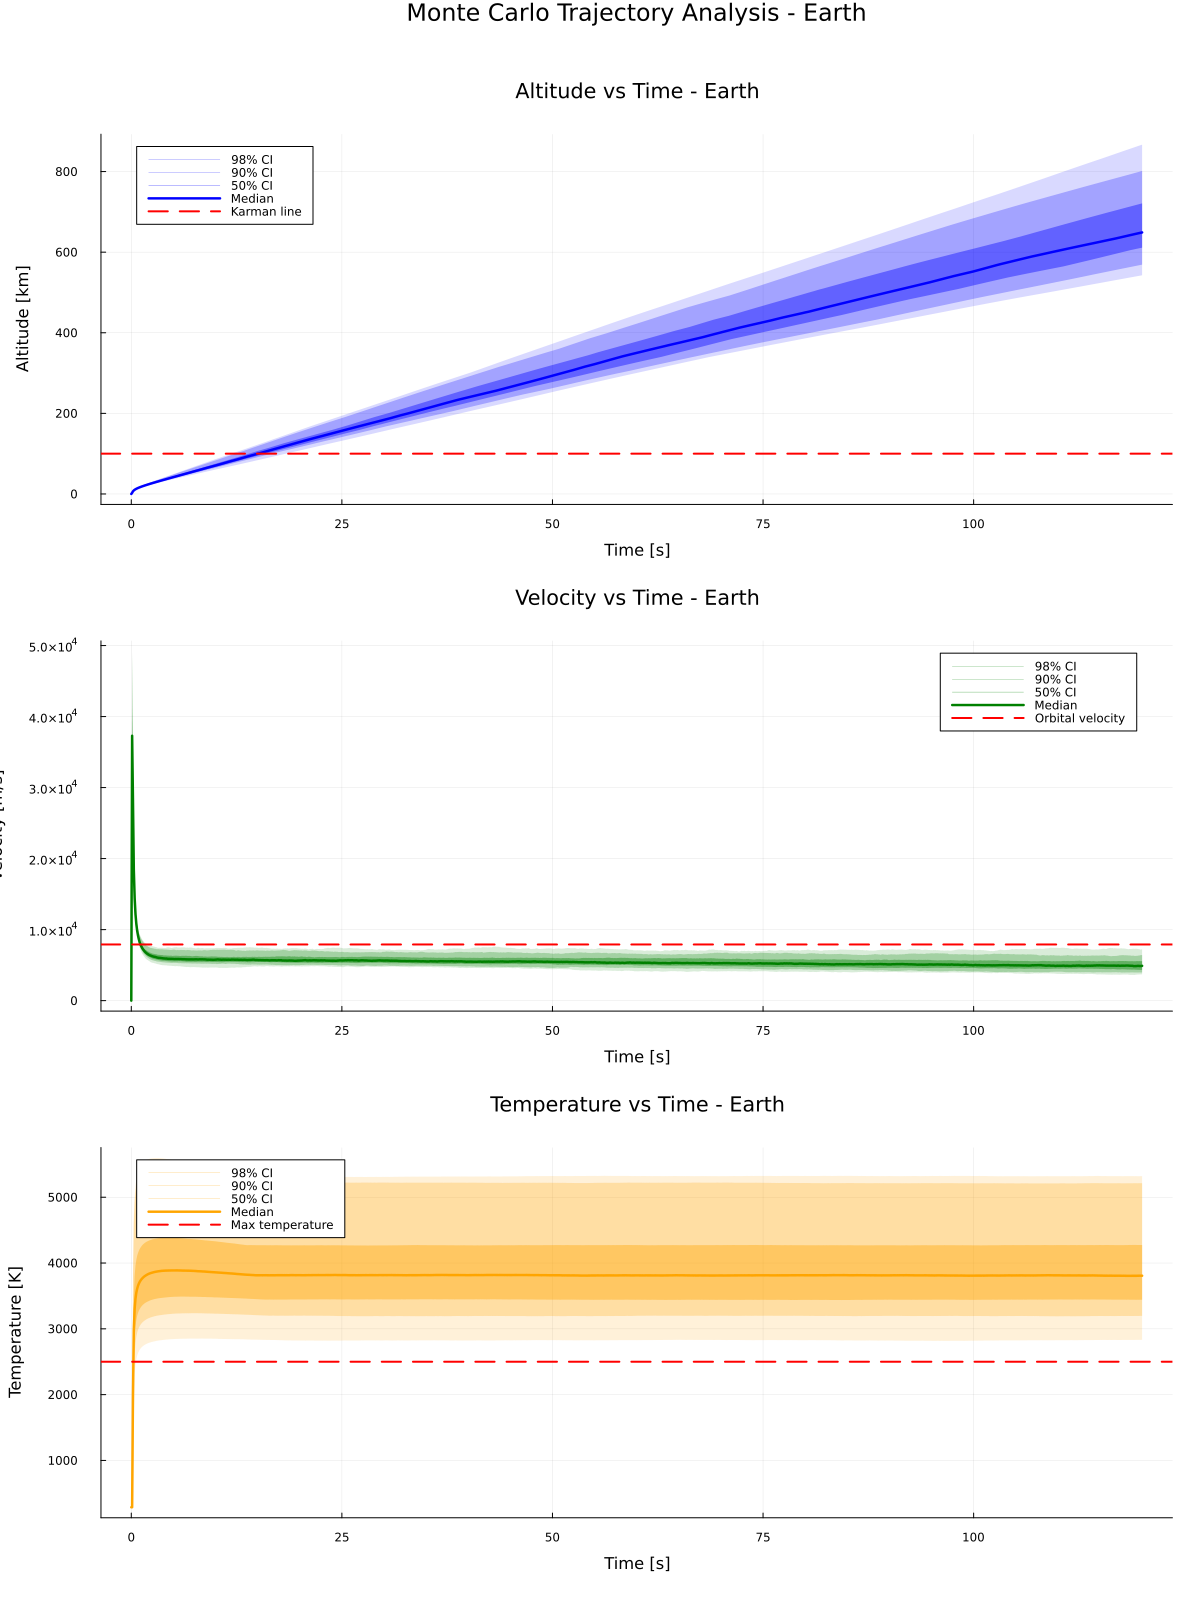

In [15]:
p = plot_monte_carlo_results(results, size=(1200, 1600))
display(p)

## Key Insights

**Physical:**
- **Vacuum tube is critical:** 99.99% vacuum eliminates atmospheric drag during acceleration
- 5 km tube @ 18 kV → ~4 km/s exit velocity (40% efficiency)
- Without vacuum: Drag losses would be ~50% of energy
- Near-vertical launch (88°) minimizes post-exit atmospheric losses
- Ultra-low heating in vacuum tube

**Statistical:**
- Layered CIs (50%/90%/98%) show probability distribution
- Monte Carlo quantifies uncertainty and risk
- 10 runs for testing, 100+ for production

**Next Steps:**
- Try different vacuum levels (0.001 = 99.9%, 0.01 = 99%)
- Adjust `voltage_per_coil` (15-20 kV range)
- Vary `length` and `num_coils`
- Increase `n_runs` for better statistics